<a href="https://colab.research.google.com/github/KOMBOU12/Marius/blob/main/Adversarial_Robustness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet ADVERSARIAL ROBUSTNESS**

Dans ce projet nous allons faire tourner les codes présents dans ce lien https://adversarial-ml-tutorial.org/ et les implémenter avec un jeu de donnée différent

## **Chapter 1 - Introduction to adversarial robustness**

Nous avons modifié la photo de porc initiale. On commence par charger l'image et on redimensione

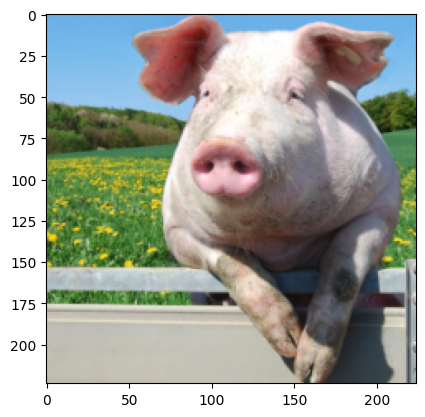

In [1]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

On pré-entraînne le modèle ResNet50

In [2]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


In [3]:
# form predictions
pred = model(norm(pig_tensor))

Nous avons modifié le code original qui ne fonctionnait pas et on l'a remplacé par ça

In [4]:
import torchvision
import json
import urllib

# Télécharger le fichier si nécessaire
url = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
class_index_path = 'imagenet_classes.txt'

urllib.request.urlretrieve(url, class_index_path)

# Lire les classes d'ImageNet directement depuis le fichier
with open(class_index_path) as f:
    imagenet_classes = [line.strip() for line in f.readlines()]

# Exemple d'utilisation avec une prédiction (remplace 'pred' par la vraie prédiction de ton modèle)
pred = torch.tensor([[0.1, 0.05, 0.8]])  # Exemple de prédiction simulée
predicted_class = pred.argmax(dim=1).item()  # Obtenir la classe prédite
print(f"Classe prédite : {imagenet_classes[predicted_class]}")


Classe prédite : great white shark


Entropie croisé

In [5]:
# 341 is the class index corresponding to "hog"
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())

0.005221420433372259


Une perte de 0,0053 est assez faible : selon les conventions du texte, cela correspondrait à une probabilité élévé que le classificateur croie qu'il s'agit d'un cochon.

**Création d'un exemple adversarial**

 Projected Gradient Descent


In [6]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

0 -0.005221420433372259
5 -12.215496063232422
10 -21.380525588989258
15 -17.23942756652832
20 -22.896841049194336
25 -21.436731338500977
True class probability: 7.019978348621336e-11


Après  30 étapes de gradient, le ResNet50 pense que cela a moins d'une chance sur $10^{-10}$ d'être un cochon.

In [7]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  American Staffordshire terrier
Predicted probability: 0.9606519937515259


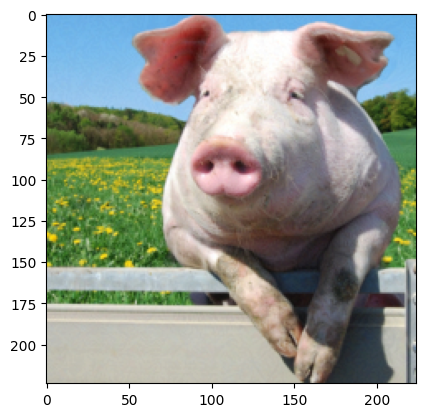

In [10]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

Voici en fait le delta que nous avons ajouté à l'image, fortement agrandi par un facteur de 50 car il serait impossible de le voir autrement.

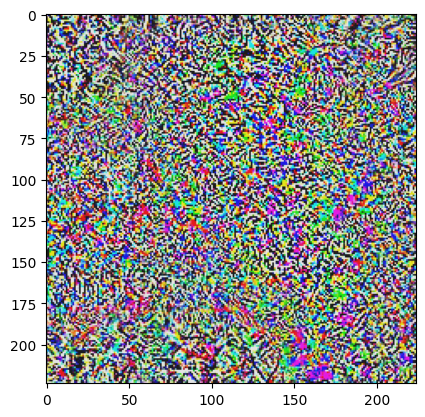

In [9]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

**Attaques ciblées**

In [11]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) +
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 20.150226593017578
10 -7.929325580596924
20 -21.327707290649414
30 -31.713909149169922
40 -38.53013610839844
50 -43.785457611083984
60 -45.197906494140625
70 -50.17829895019531
80 -53.76795959472656
90 -56.57528305053711


In [12]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  airliner
Predicted probability: 0.9998670816421509


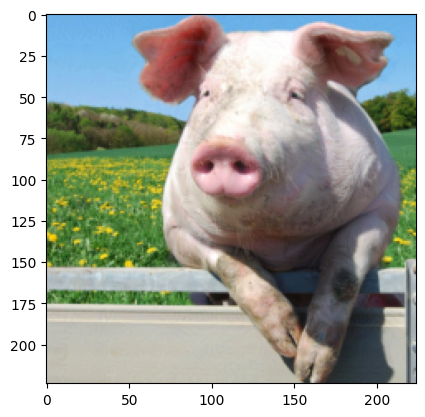

In [13]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

Ajout d'un bruit d'avion de ligne

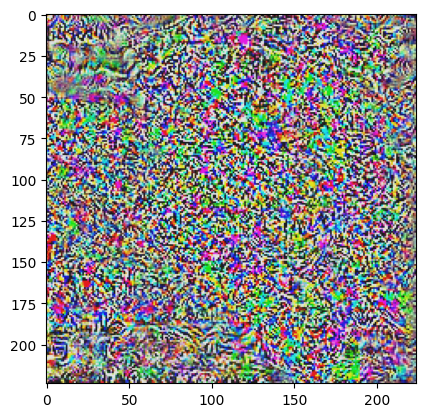

In [14]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

La conclusion,  est qu'avec les attaques adverses et le deep learning, vous pouvez faire voler les cochons.

Les algorithmes de deep learning sont incroyablement fragiles, et les exemples adversariaux mettent ce fait en évidence de manière très claire et intuitive.

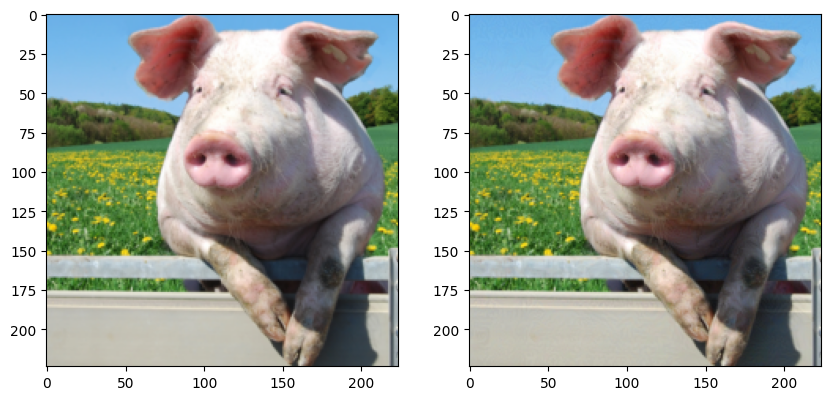

In [15]:
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow((pig_tensor)[0].detach().numpy().transpose(1,2,0))
ax[1].imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

## **Chapter 2 - linear models**

Nous refaisons l'algorithme avec le jeu de données Fashion-MNIST au lieu du jeu de données MNIST. Fashion-MNIST est un jeu de données similaire à MNIST, mais il contient des images de vêtements (t-shirts, pantalons, etc.) plutôt que des chiffres.

Le code implémente une régression logistique pour un sous-ensemble du jeu de données Fashion-MNIST, en se concentrant uniquement sur les deux premières classes (T-shirts/hauts et pantalons), pour en faire un problème de classification binaire.

In [16]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim



# Charger les données Fashion-MNIST
fashion_train = datasets.FashionMNIST("./data", train=True, download=True, transform=transforms.ToTensor())
fashion_test = datasets.FashionMNIST("./data", train=False, download=True, transform=transforms.ToTensor())

# Pour simplifier, on garde uniquement les deux premières classes (T-shirts/hauts et pantalons)
train_idx = fashion_train.targets <= 1
fashion_train.data = fashion_train.data[train_idx]
fashion_train.targets = fashion_train.targets[train_idx]

test_idx = fashion_test.targets <= 1
fashion_test.data = fashion_test.data[test_idx]
fashion_test.targets = fashion_test.targets[test_idx]

# Créer les DataLoaders
train_loader = DataLoader(fashion_train, batch_size=100, shuffle=True)
test_loader = DataLoader(fashion_test, batch_size=100, shuffle=False)

# Définir le modèle de régression logistique (réseau neuronal linéaire)
model = nn.Linear(784, 1)

# Définir l'optimiseur
opt = optim.SGD(model.parameters(), lr=1.)


# Fonction pour une seule passe sur les données
def epoch(loader, model, opt=None):
    total_loss, total_err = 0., 0.
    for X, y in loader:
        X = X.view(X.shape[0], -1)  # Redimensionner les images en vecteurs
        yp = model(X)[:, 0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())  # Perte binaire pour les deux classes
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += ((yp > 0) * (y == 0) + (yp < 0) * (y == 1)).sum().item()
        total_loss += loss.item() * X.shape[0]

    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

# Entraîner le modèle et évaluer sur les données de test
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
for i in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.0MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 273kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.01MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 9.28MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train Err	Train Loss	Test Err	Test Loss
0.039333	0.216738	0.020000	0.054502
0.016667	0.047608	0.022500	0.058488
0.014000	0.041632	0.042000	0.139501
0.013333	0.039373	0.017500	0.044084
0.012083	0.035645	0.014000	0.037414
0.010750	0.033753	0.015000	0.037903
0.011417	0.033389	0.012500	0.035013
0.011417	0.031817	0.014000	0.037606
0.009750	0.032021	0.014000	0.036859
0.009583	0.029511	0.016000	0.037292


 Visualisation des prédictions et à génération d'exemples adversariaux pour un modèle de régression logistique

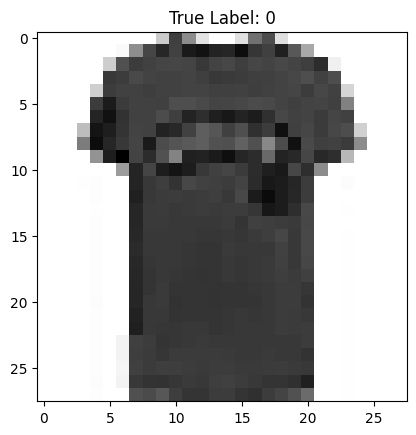

In [19]:
import matplotlib.pyplot as plt

# Modèle de régression logistique (linéaire)
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=0.1)


# Passer les images de test au format correct pour les utiliser avec le modèle
X_test = (test_loader.dataset.data.float() / 255).view(len(test_loader.dataset), -1)
y_test = test_loader.dataset.targets
yp = model(X_test)[:, 0]

# Filtrer les prédictions correctes
idx = (yp > 0) * (y_test == 0) + (yp < 0) * (y_test == 1)
correct_idx = torch.nonzero(idx)[0].item()  # Sélectionner le premier indice correct

# Afficher l'image correspondante
plt.imshow(1 - X_test[correct_idx].view(28, 28).numpy(), cmap="gray")
plt.title("True Label: {}".format(y_test[correct_idx].item()))
plt.show()



 Une perturbation adversariale est générée en utilisant les poids du modèle.

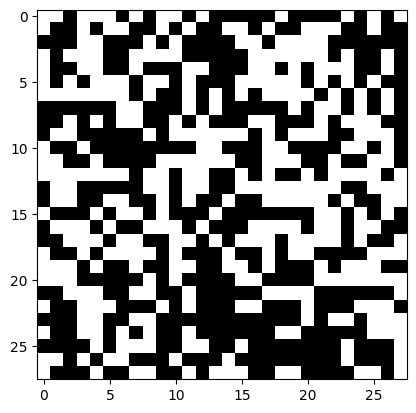

In [20]:
# Génération de perturbation adversariale
epsilon = 0.2
delta = epsilon * model.weight.detach().sign().view(28, 28)
plt.imshow(1 - delta.numpy(), cmap="gray")
plt.show()

(1.0, 2.8846107840538027)


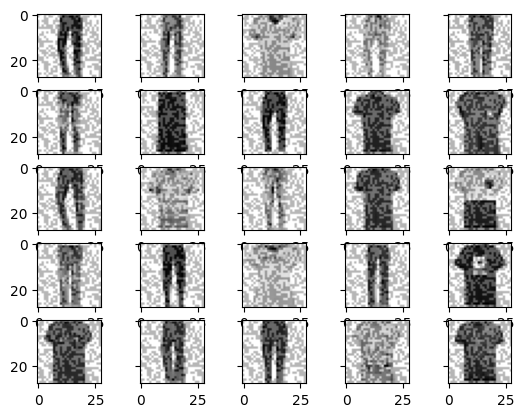

In [21]:
# Fonction pour l'entraînement avec des attaques adversariales
def epoch_adv(loader, model, delta):
    total_loss, total_err = 0., 0.
    for X, y in loader:
        yp = model((X - (2 * y.float()[:, None, None, None] - 1) * delta).view(X.shape[0], -1))[:, 0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y == 0) + (yp < 0) * (y == 1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

# Calcul des erreurs avec perturbation
print(epoch_adv(test_loader, model, delta[None, None, :, :]))

# Visualiser plusieurs images modifiées adversarialement
f, ax = plt.subplots(5, 5, sharey=True)
for i in range(25):
    ax[i % 5][i // 5].imshow(1 - (X_test[i].view(28, 28) - (2 * y_test[i] - 1) * delta).numpy(), cmap="gray")
plt.show()

Ainsi, en autorisant des perturbations dans la boule ℓ∞ de taille ϵ=0,2, le classificateur passe d'une erreur pratiquement nulle à une erreur de 100 %. Mais l'oeil humain est toujours capable de reconnaître les vêtements.

**Entraînement des modèles robuste linéaire**

In [22]:
# Fonction d'entraînement robuste avec perturbations adversariales
def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err = 0., 0.
    for X, y in loader:
        yp = model(X.view(X.shape[0], -1))[:, 0] - epsilon * (2 * y.float() - 1) * model.weight.norm(1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        total_err += ((yp > 0) * (y == 0) + (yp < 0) * (y == 1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [23]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1e-1)
epsilon = 0.2
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(20):
    train_err, train_loss = epoch_robust(train_loader, model, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.564833	1.869622	0.594500	0.998954
0.581167	1.777760	0.474500	1.012138
0.565750	1.622802	0.563500	2.686669
0.567917	1.613496	0.595000	1.783941
0.562417	1.614677	0.613000	1.371234
0.557083	1.550990	0.559500	1.519175
0.534000	1.467791	0.458500	1.258572
0.544083	1.539142	0.561500	2.160428
0.523250	1.477758	0.384000	1.192112
0.525667	1.491906	0.603000	1.831112
0.525333	1.455805	0.609000	1.580137
0.527750	1.475051	0.356500	0.957553
0.509583	1.415401	0.534500	1.617526
0.521583	1.469637	0.610500	1.501597
0.503417	1.379080	0.616500	1.311802
0.507083	1.411213	0.555000	1.759311
0.498917	1.436848	0.550000	1.692543
0.503667	1.407021	0.446500	1.356932
0.524500	1.392968	0.600500	1.924385
0.523167	1.485073	0.309000	0.927174


In [24]:
train_err, train_loss = epoch(train_loader, model)
test_err, test_loss = epoch(test_loader, model)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.064000	0.151611	0.064500	0.155961


On obtient une de 6% qui est très élévé comparément à l'erreur qui a été obtenu sur le jeu de donnée initiale

Le modèle montre une robustesse modérée face aux perturbations adversariales, mais il est encore affecté par une erreur relativement élevée sur les exemples perturbés.

# **Chapter 3 - Adversarial examples, solving the inner maximization**

On continue avec le jeu de données Fashion-MNIST à la place de MNIST.

Lorsque nous passons aux réseaux de neurones, plusieurs défis surgissent, en raison du fait que la surface de perte des réseaux de neurones standards est beaucoup plus « irrégulière » que celle des modèles linéaires.

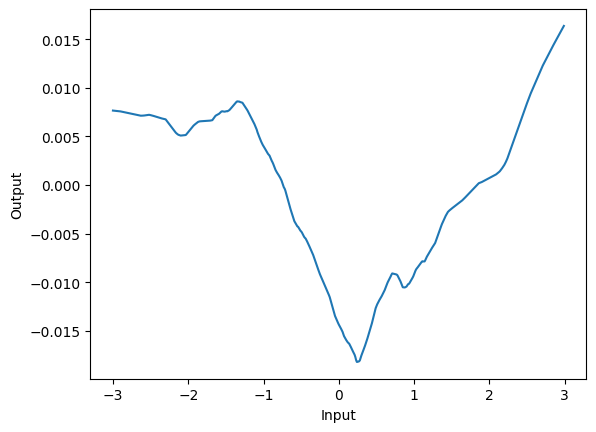

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Définir le dispositif d'exécution (GPU ou CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Fixer la graine aléatoire pour la reproductibilité
torch.manual_seed(0)

# Définir le modèle simple (régression avec 3 couches cachées)
model = nn.Sequential(nn.Linear(1, 100), nn.ReLU(),
                      nn.Linear(100, 100), nn.ReLU(),
                      nn.Linear(100, 100), nn.ReLU(),
                      nn.Linear(100, 1))
opt = optim.SGD(model.parameters(), lr=1e-2)

# Entraîner le modèle simple sur des données aléatoires
for _ in range(100):
    loss = nn.MSELoss()(model(torch.randn(100, 1)), torch.randn(100, 1))
    opt.zero_grad()
    loss.backward()
    opt.step()

# Visualisation des résultats
import numpy as np
plt.plot(np.arange(-3, 3, 0.01), model(torch.arange(-3, 3, 0.01)[:, None]).detach().numpy())
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()



Les réseaux de neurones, de par la nature de leurs surfaces de perte, sont particulièrement sensibles aux exemples adverses.

On entraînne quelques modèles

In [2]:
# Définir la classe Flatten
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

# Définir les modèles DNN et CNN pour Fashion-MNIST
model_dnn_2 = nn.Sequential(Flatten(), nn.Linear(784, 200), nn.ReLU(),
                            nn.Linear(200, 10)).to(device)

model_dnn_4 = nn.Sequential(Flatten(), nn.Linear(784, 200), nn.ReLU(),
                            nn.Linear(200, 100), nn.ReLU(),
                            nn.Linear(100, 100), nn.ReLU(),
                            nn.Linear(100, 10)).to(device)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7 * 7 * 64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)





 Jeu de données Fashion-MNIST

In [3]:
# Charger les données Fashion-MNIST
fashion_train = datasets.FashionMNIST("../data", train=True, download=True, transform=transforms.ToTensor())
fashion_test = datasets.FashionMNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(fashion_train, batch_size=100, shuffle=True)
test_loader = DataLoader(fashion_test, batch_size=100, shuffle=False)

100%|██████████| 26.4M/26.4M [00:00<00:00, 117MB/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 24.1MB/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 70.0MB/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 15.0MB/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [4]:
# Fonction pour effectuer une passe d'entraînement/évaluation
def epoch(loader, model, opt=None):
    total_loss, total_err = 0., 0.
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp, y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

# Entraîner le modèle DNN à 2 couches et afficher les résultats
opt = optim.SGD(model_dnn_2.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_2, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_2)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")


0.234850	0.681968	0.179100	0.506035
0.165017	0.468272	0.160000	0.454988
0.149417	0.419783	0.152200	0.427811
0.139417	0.389423	0.155300	0.428977
0.131933	0.369957	0.143300	0.408889
0.127367	0.355353	0.140700	0.389617
0.123433	0.340588	0.140900	0.391266
0.119933	0.330525	0.131000	0.367854
0.116183	0.319683	0.134100	0.374551
0.112867	0.310470	0.130600	0.361844


In [5]:
opt = optim.SGD(model_dnn_4.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_4, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_4)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.334433	0.895602	0.195300	0.543630
0.175550	0.484458	0.172500	0.493532
0.154450	0.418874	0.153400	0.429280
0.140100	0.380156	0.135200	0.386191
0.131983	0.355725	0.138700	0.380602
0.124633	0.338659	0.129900	0.360367
0.118933	0.322661	0.142400	0.383693
0.115083	0.309577	0.128800	0.351390
0.110817	0.299946	0.123200	0.346719
0.108067	0.287955	0.132700	0.361918


In [6]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.306533	0.820032	0.196600	0.533534
0.147083	0.397946	0.136000	0.372931
0.122567	0.330945	0.128700	0.341846
0.107067	0.293315	0.113400	0.309236
0.099017	0.266712	0.113500	0.307501
0.080517	0.219587	0.101000	0.276822
0.078000	0.211527	0.099700	0.276000
0.076233	0.207005	0.099600	0.272035
0.075117	0.202884	0.098600	0.269457
0.073783	0.199018	0.097900	0.270247


Pour ne pas re-run tout le code d'en haut

In [7]:
torch.save(model_dnn_2.state_dict(), "model_dnn_2.pt")
torch.save(model_dnn_4.state_dict(), "model_dnn_4.pt")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

model_dnn_2.load_state_dict(torch.load("model_dnn_2.pt"))
model_dnn_4.load_state_dict(torch.load("model_dnn_4.pt"))
model_cnn.load_state_dict(torch.load("model_cnn.pt"))

<ipython-input-7-6b561f976e92>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dnn_2.load_state_dict(torch.load("model_dnn_2.pt"))
<ipython-input-7-6b561f976e92>:6: F

<All keys matched successfully>


Les modèles ci-dessus serviront de banc d'essai pour étudier la capacité des différentes méthodes à résoudre le problème de maximisation interne qui nous intéresse.

**Inner maximization using back-propagation**

FGSM est spécifiquement une attaque sous une contrainte de norme ℓ∞ : FGSM est simplement une étape unique de descente de gradient projetée sous la contrainte ℓ∞.

In [8]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

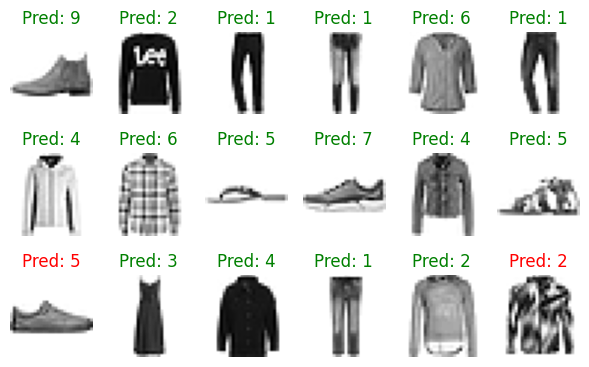

In [9]:
yp = model_dnn_2(X)
plot_images(X, y, yp, 3, 6)

Nous passons de deux prédictions incorrectes à zéro prédiction correcte pour l'ensemble complet que nous considérons.

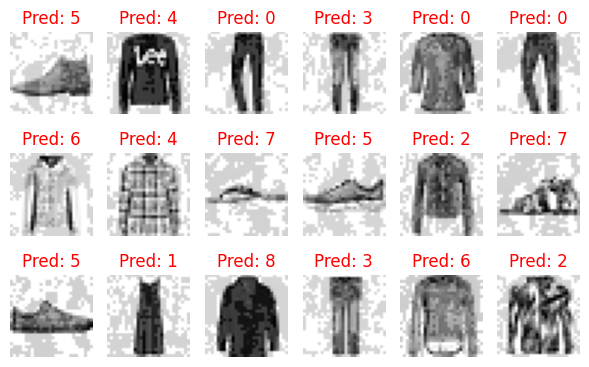

In [10]:
### Illustrate attacked images
delta = fgsm(model_dnn_2, X, y, 0.1)
yp = model_dnn_2(X + delta)
plot_images(X+delta, y, yp, 3, 6)

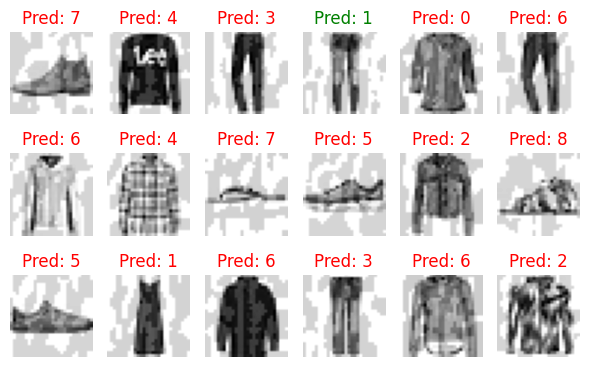

In [11]:
### Illustrate attacked images
delta = fgsm(model_cnn, X, y, 0.1)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

Evaluation des performances de la méthode d'attaque plus rigoureusement

In [12]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [13]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.1)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, fgsm, 0.1)[0])
print("        CNN:", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0])

2-layer DNN: 0.9537
4-layer DNN: 0.9201
        CNN: 0.9573


**Projected gradient descent**

In [14]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

On obtient des adversarials exemples pour presque tous les cas

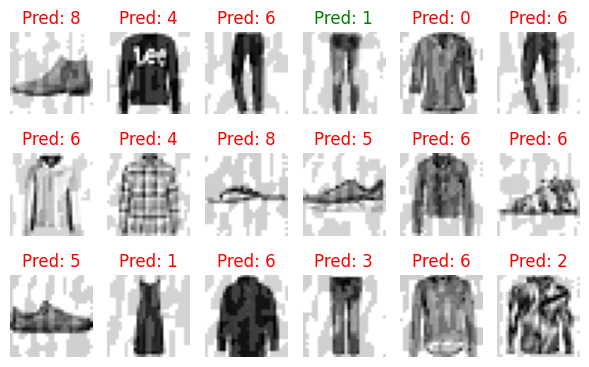

In [15]:
### Illustrate attacked images
delta = pgd(model_cnn, X, y, 0.1, 1e4, 1000)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [16]:
delta = torch.zeros_like(X, requires_grad=True)
loss = nn.CrossEntropyLoss()(model_cnn(X + delta), y)
loss.backward()
print(delta.grad.abs().mean().item())

0.00037350200000219047


 **steepest descent**

In [17]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

On obtient encore des adversarial examples pour tous les cas

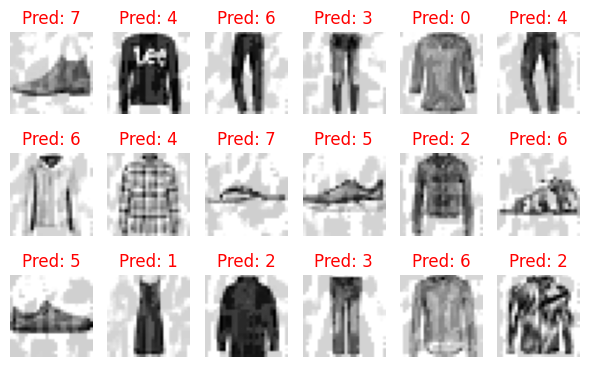

In [18]:
### Illustrate attacked images
delta = pgd_linf(model_cnn, X, y, epsilon=0.1, alpha=1e-2, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [19]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])

2-layer DNN: 0.9782
4-layer DNN: 0.9895
CNN: 0.9998


Cela représente une amélioration raisonnable par rapport à l'attaque FGSM.

Cette approche,  augmente également le temps d'exécution par un facteur égal au nombre de redémarrages

In [20]:
def pgd_linf_rand(model, X, y, epsilon, alpha, num_iter, restarts):
    """ Construct PGD adversarial examples on the samples X, with random restarts"""
    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)

    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon

        for t in range(num_iter):
            loss = nn.CrossEntropyLoss()(model(X + delta), y)
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.grad.zero_()

        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X+delta),y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    return max_delta

In [21]:
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_linf_rand, 0.1, 1e-2, 40, 10)[0])

CNN: 1.0


**Targeted attacks**

In [23]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

On utilise une grande région de perturbation ϵ=0,2

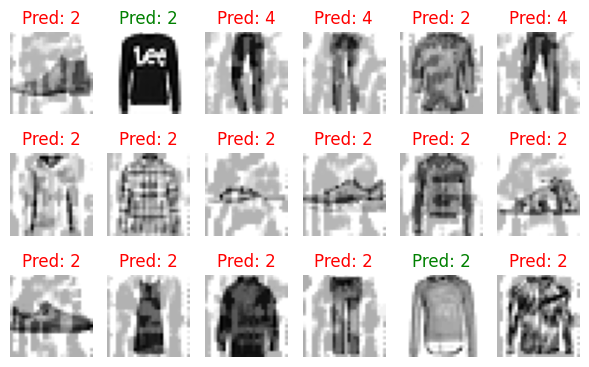

In [24]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=2)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)


In [25]:
def pgd_linf_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = 2*yp[:,y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

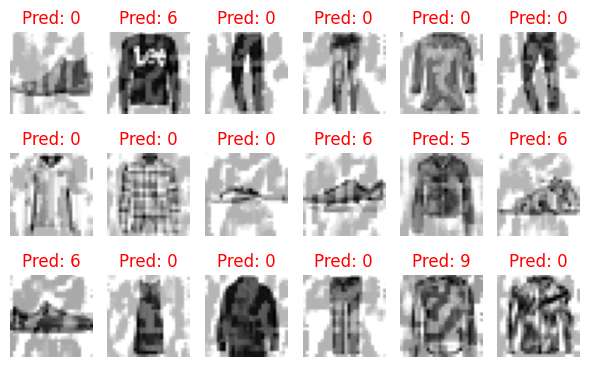

In [26]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

Contrairement aux résultats du jeu de donnée utilisé dans l'article le modèle de classification se laisse tromper totalement pour une pertubation avec notre jeu de donnée

In [27]:
def norms(Z):
    """Compute norms over all but the first dimension"""
    return Z.view(Z.shape[0], -1).norm(dim=1)[:,None,None,None]


def pgd_l2(model, X, y, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data += alpha*delta.grad.detach() / norms(delta.grad.detach())
        delta.data = torch.min(torch.max(delta.detach(), -X), 1-X) # clip X+delta to [0,1]
        delta.data *= epsilon / norms(delta.detach()).clamp(min=epsilon)
        delta.grad.zero_()

    return delta.detach()

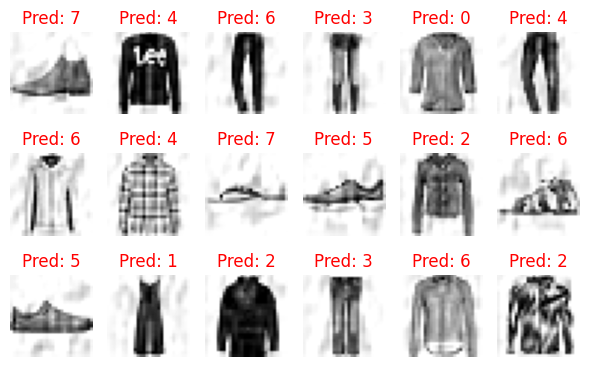

In [28]:
delta = pgd_l2(model_cnn, X, y, epsilon=2, alpha=0.1, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [30]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, pgd_l2, 2, 0.1, 40)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, pgd_l2, 2, 0.1, 40)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_l2, 2, 0.1, 40)[0])

2-layer DNN: 0.9501
4-layer DNN: 0.9599
CNN: 0.9995


**Finding upper and lower bounds**

In [31]:
def bound_propagation(model, initial_bound):
    l, u = initial_bound
    bounds = []

    for layer in model:
        if isinstance(layer, Flatten):
            l_ = Flatten()(l)
            u_ = Flatten()(u)
        elif isinstance(layer, nn.Linear):
            l_ = (layer.weight.clamp(min=0) @ l.t() + layer.weight.clamp(max=0) @ u.t()
                  + layer.bias[:,None]).t()
            u_ = (layer.weight.clamp(min=0) @ u.t() + layer.weight.clamp(max=0) @ l.t()
                  + layer.bias[:,None]).t()
        elif isinstance(layer, nn.Conv2d):
            l_ = (nn.functional.conv2d(l, layer.weight.clamp(min=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(u, layer.weight.clamp(max=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])

            u_ = (nn.functional.conv2d(u, layer.weight.clamp(min=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(l, layer.weight.clamp(max=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])

        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)

        bounds.append((l_, u_))
        l,u = l_, u_
    return bounds

In [32]:
epsilon = 0.1
bounds = bound_propagation(model_cnn, ((X - epsilon).clamp(min=0), (X + epsilon).clamp(max=1)))
print("lower bound: ", bounds[-1][0][0].detach().cpu().numpy())
print("upper bound: ", bounds[-1][1][0].detach().cpu().numpy())

lower bound:  [-2625.3784 -3353.668  -3487.8455 -3447.4846 -3149.6257 -4412.2515
 -2982.0217 -3669.337  -3919.71   -4083.683 ]
upper bound:  [3641.0796 2568.2012 3703.084  3381.8616 3636.4924 3717.5918 4319.7856
 3177.2578 4040.3325 3026.832 ]


Donc, ces limites nous indiquent que pour une perturbation delta de ϵ=0,1, le logit correspondant à la classe zéro pour le premier exemple de test Fashion MNIST se situe quelque part dans l'intervalle [-2626, 3642].

**A final integer programming formulation**

In [33]:
import cvxpy as cp

def form_milp(model, c, initial_bounds, bounds):
    linear_layers = [(layer, bound) for layer, bound in zip(model,bounds) if isinstance(layer, nn.Linear)]
    d = len(linear_layers)-1

    # create cvxpy variables
    z = ([cp.Variable(layer.in_features) for layer, _ in linear_layers] +
         [cp.Variable(linear_layers[-1][0].out_features)])
    v = [cp.Variable(layer.out_features, boolean=True) for layer, _ in linear_layers[:-1]]

    # extract relevant matrices
    W = [layer.weight.detach().cpu().numpy() for layer,_ in linear_layers]
    b = [layer.bias.detach().cpu().numpy() for layer,_ in linear_layers]
    l = [l[0].detach().cpu().numpy() for _, (l,_) in linear_layers]
    u = [u[0].detach().cpu().numpy() for _, (_,u) in linear_layers]
    l0 = initial_bound[0][0].view(-1).detach().cpu().numpy()
    u0 = initial_bound[1][0].view(-1).detach().cpu().numpy()

    # add ReLU constraints
    constraints = []
    for i in range(len(linear_layers)-1):
        constraints += [z[i+1] >= W[i] @ z[i] + b[i],
                        z[i+1] >= 0,
                        cp.multiply(v[i], u[i]) >= z[i+1],
                        W[i] @ z[i] + b[i] >= z[i+1] + cp.multiply((1-v[i]), l[i])]

    # final linear constraint
    constraints += [z[d+1] == W[d] @ z[d] + b[d]]

    # initial bound constraints
    constraints += [z[0] >= l0, z[0] <= u0]

    return cp.Problem(cp.Minimize(c @ z[d+1]), constraints), (z, v)

In [34]:
model_small = nn.Sequential(Flatten(), nn.Linear(784,50), nn.ReLU(),
                            nn.Linear(50,20), nn.ReLU(),
                            nn.Linear(20,10)).to(device)

In [35]:
# train model and save to disk
opt = optim.SGD(model_small.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_small, opt)
    test_err, test_loss = epoch(test_loader, model_small)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")
torch.save(model_small.state_dict(), "model_small.pt")

0.322317	0.868322	0.195700	0.560365
0.182800	0.513223	0.186400	0.502919
0.161233	0.445816	0.160000	0.440498
0.148417	0.412169	0.156600	0.430430
0.143733	0.390355	0.152100	0.424742
0.136233	0.371469	0.144500	0.401095
0.131683	0.356272	0.152700	0.405947
0.125917	0.342278	0.145700	0.397444
0.123350	0.333817	0.134600	0.373952
0.120100	0.323308	0.132200	0.362636


In [36]:
# load model from disk
model_small.load_state_dict(torch.load("model_small.pt"))

<ipython-input-36-7ec2c9e17e52>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_small.load_state_dict(torch.load("model_small.pt"))


<All keys matched successfully>

In [37]:
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)
c = np.zeros(10)
c[y[0].item()] = 1
c[2] = -1

prob, (z, v) = form_milp(model_small, c, initial_bound, bounds)

Enfin, résolvons le programme entier en utilisant Gurobi.

In [39]:
pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 39.3 MB/s eta 0:00:00


In [42]:

import cvxpy as cp
print(cp.installed_solvers())

['CLARABEL', 'CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']


In [43]:
prob.solve(solver=cp.GUROBI, verbose=True)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Oct 27 07:41:20 AM: Your problem has 934 variables, 1858 constraints, and 0 parameters.
(CVXPY) Oct 27 07:41:20 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 27 07:41:20 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 27 07:41:20 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 27 07:41:20 AM: Your problem is compiled with the CPP canonicalization backend.


SolverError: The solver GUROBI is not installed.

# **Chapter 4 - Adversarial training, solving the outer minimization**

Nous revenons au problème de min-max que nous avons posé dans le tout premier chapitre, lequel correspond à la tâche d'entraîner un modèle robuste aux attaques adversariales.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Remplacement de MNIST par FashionMNIST
fashion_mnist_train = datasets.FashionMNIST("../data", train=True, download=True, transform=transforms.ToTensor())
fashion_mnist_test = datasets.FashionMNIST("../data", train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(fashion_mnist_train, batch_size=100, shuffle=True)
test_loader = DataLoader(fashion_mnist_test, batch_size=100, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.5MB/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 275kB/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.04MB/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.13MB/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [2]:
torch.manual_seed(0)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [3]:
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

La seule modification réelle que nous faisons est que nous modifions la fonction adversariale pour permettre également l'entraînement.

In [4]:
def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

On entraîne un modèle standard et on évalue l'erreur adversarial.

L'entraînement du modèle prend trop de temps (39 min)

In [5]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

0.343267	0.168400	0.907000
0.148633	0.141700	0.947700
0.124733	0.127300	0.960400
0.112267	0.118000	0.990400
0.102833	0.113500	0.992900
0.085367	0.104800	0.991900
0.082933	0.103000	0.992900
0.081417	0.103200	0.995900
0.079917	0.103700	0.993000
0.078683	0.100200	0.995300


A chaque itération l'erreur adversarial est la plus élévée

In [6]:
model_cnn.load_state_dict(torch.load("model_cnn.pt"))

<ipython-input-6-ce2995a533f8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cnn.load_state_dict(torch.load("model_cnn.pt"))


<All keys matched successfully>

Pourquoi ces modèles fonctionnent-ils bien contre les attaques robustes, et pourquoi certaines autres méthodes proposées pour entraîner des modèles robustes ont-elles notoirement échoué à cet égard ?

In [10]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

In [11]:
def draw_loss(model, X, epsilon):
    Xi, Yi = np.meshgrid(np.linspace(-epsilon, epsilon,100), np.linspace(-epsilon,epsilon,100))

    def grad_at_delta(delta):
        delta.requires_grad_(True)
        nn.CrossEntropyLoss()(model(X+delta), y[0:1]).backward()
        return delta.grad.detach().sign().view(-1).cpu().numpy()

    dir1 = grad_at_delta(torch.zeros_like(X, requires_grad=True))
    delta2 = torch.zeros_like(X, requires_grad=True)
    delta2.data = torch.tensor(dir1).view_as(X).to(device)
    dir2 = grad_at_delta(delta2)
    np.random.seed(0)
    dir2 = np.sign(np.random.randn(dir1.shape[0]))

    all_deltas = torch.tensor((np.array([Xi.flatten(), Yi.flatten()]).T @
                              np.array([dir2, dir1])).astype(np.float32)).to(device)
    yp = model(all_deltas.view(-1,1,28,28) + X)
    Zi = nn.CrossEntropyLoss(reduction="none")(yp, y[0:1].repeat(yp.shape[0])).detach().cpu().numpy()
    Zi = Zi.reshape(*Xi.shape)
    #Zi = (Zi-Zi.min())/(Zi.max() - Zi.min())

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ls = LightSource(azdeg=0, altdeg=200)
    rgb = ls.shade(Zi, plt.cm.coolwarm)

    surf = ax.plot_surface(Xi, Yi, Zi, rstride=1, cstride=1, linewidth=0,
                       antialiased=True, facecolors=rgb)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
draw_loss(model_cnn, X[0:1], 0.1)

TypeError: FigureBase.gca() got an unexpected keyword argument 'projection'

<Figure size 1000x1000 with 0 Axes>